# Modeling

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [42]:
df = pd.read_csv('../datasets/exogenous.csv')

In [43]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [51]:
df.shape

(4605, 9)

In [45]:
zip_10002 =df.loc[df['zip_code']==10002]

In [46]:
zip_10002['year_month']=pd.to_datetime(zip_10002['year_month'])

/Users/zhan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
zip_10002.set_index('year_month',inplace = True)
zip_10002 = zip_10002.astype(int)
zip_10002.head()

,zip_code,bait,clean_ups,compliance,initial,sighting,restaurant,population
year_month,,,,,,,,
2010-01-01,10002,8,0,28,91,6,600,79717
2010-02-01,10002,13,0,0,483,3,600,79717
2010-03-01,10002,4,0,73,798,5,600,79717
2010-04-01,10002,10,0,120,321,5,600,79717
2010-05-01,10002,30,0,16,7,9,600,79717


In [50]:
zip_10002.shape

(108, 8)

In [52]:
len(set(df['zip_code']))

84

In [ ]:
zip_10002

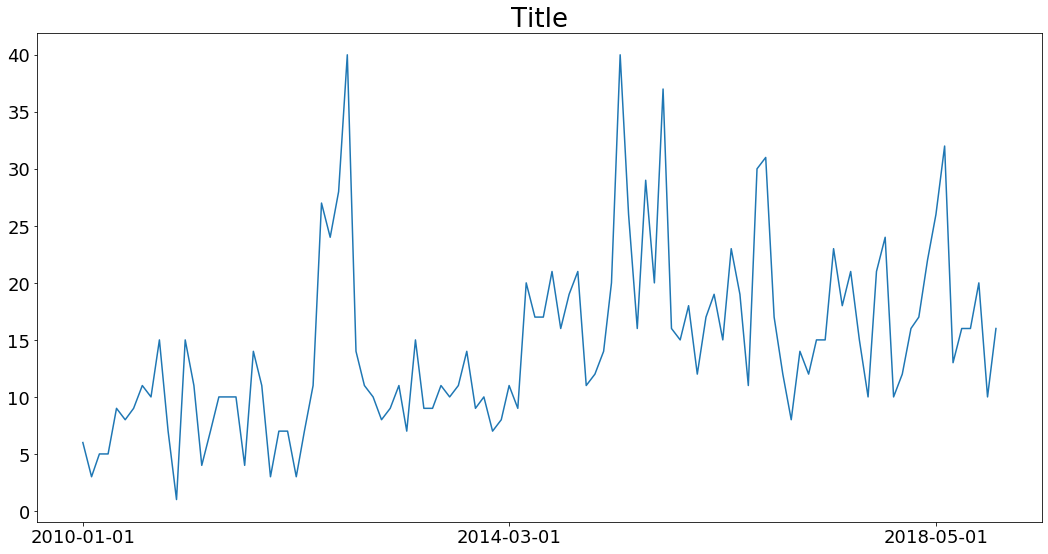

In [48]:
plot_series(zip_10002,
            ['sighting'],
            steps=50)

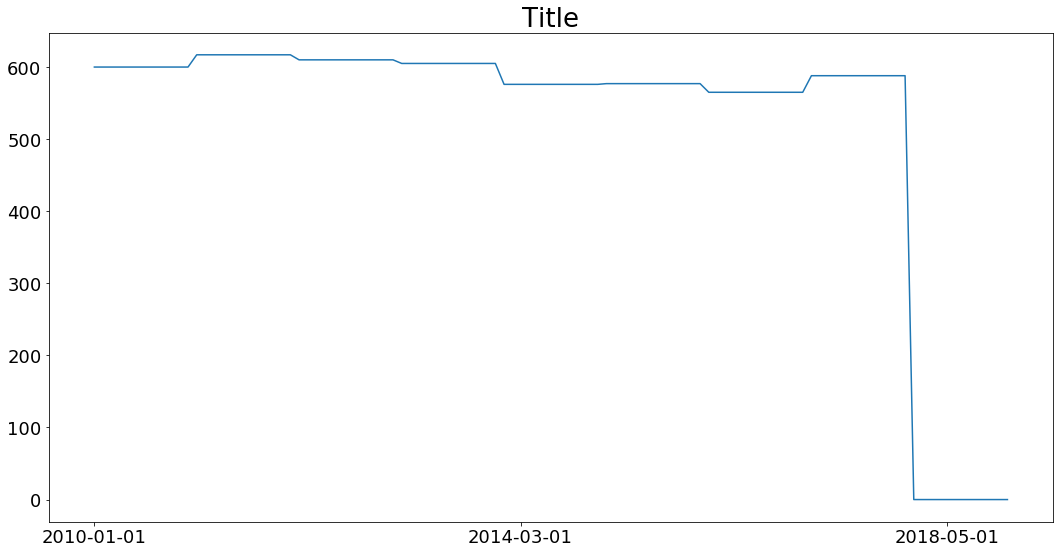

In [49]:
plot_series(zip_10002,
            ['restaurant'],
            steps=50)